Extracting EDF parameters from /Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant p

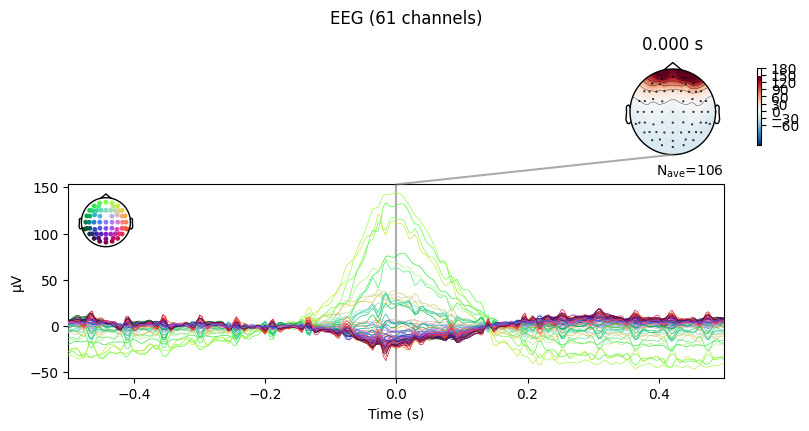

Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


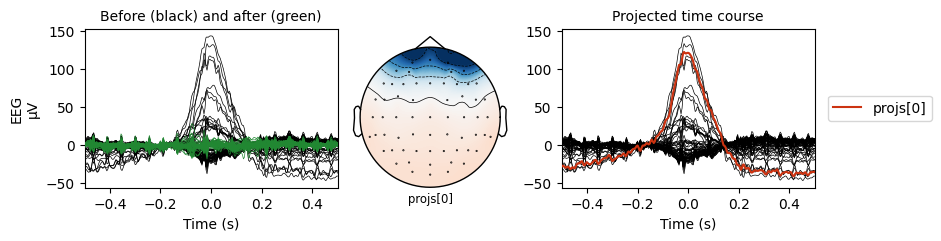

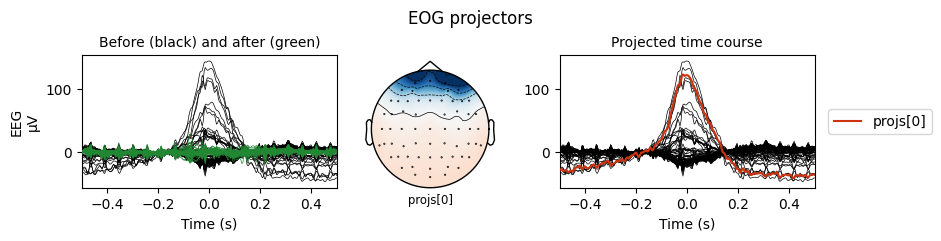

In [1]:
import mne
from eeg_research.preprocessing.tools import (blinks_remover, 
                                              utils)
raw = mne.io.read_raw("/Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf",
                      preload = True)
b_remover = blinks_remover.BlinksRemover(raw)
montage = mne.channels.make_standard_montage('easycap-M1')
b_remover.raw.set_montage(montage)
b_remover.plot_blinks_found()
b_remover.remove_blinks()
b_remover.plot_removal_results()

In [2]:
raw = b_remover.blink_removed_raw
muscle_annotations, muscle_zscore = mne.preprocessing.annotate_muscle_zscore(raw,
                                                                             filter_freq=(30,None)
)

raw.set_annotations(raw.annotations + muscle_annotations)

Using eeg sensors for muscle artifact detection
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Filter length: 111 samples (0.444 s)



Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Measurement date,"January 01, 2000 00:00:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,64 points
Good channels,"61 EEG, 1 ECG, 2 EOG"
Bad channels,None
EOG channels,"EOGL, EOGU"
ECG channels,ECG
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [3]:
import numpy as np
from scipy.ndimage import label
from mne.preprocessing.artifact_detection import _annotations_from_mask
from mne.annotations import _adjust_onset_meas_date
raw = b_remover.blink_removed_raw
def annotate_artifacts_by_zscore(raw, 
                                 channel_type='eeg', 
                                 z_thresh=3,
                                 min_artifact_gap=0.1,
                                 filtering = (1,20),
                                 min_annotation_duration = 0.5):
    """
    Annotate and group artifacts in raw EEG data based on a z-score threshold and minimum gap criteria.
    
    Parameters:
    - raw: Raw object from MNE containing EEG data.
    - channel_type: Type of channels to analyze.
    - z_thresh: Z-score threshold to use for detecting artifacts.
    - min_artifact_gap: Minimum time in seconds between separate artifacts; below this, artifacts will be grouped.
    
    Returns:
    - annotations: MNE Annotations object with detected and grouped artifacts.
    """
    raw_copy = raw.copy().filter(*filtering)
    picks = mne.pick_types(raw_copy.info, meg=False, eeg=(channel_type=='eeg'), eog=False)
    data, times = raw_copy[picks]
    
    # Compute z-score
    z_scores = np.abs((data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True))
    artifacts = (z_scores > z_thresh).any(axis=0)
    
    # Find continuous segments of artifacts and group close ones
    artifact_times = times[artifacts]
    if len(artifact_times) == 0:
        return mne.Annotations()  # Return empty annotations if no artifacts found
    
    # Initialize annotations
    onsets = [artifact_times[0]]
    ends = []
    for i in range(1, len(artifact_times)):
        if artifact_times[i] - artifact_times[i - 1] > min_artifact_gap:
            ends.append(artifact_times[i - 1])
            onsets.append(artifact_times[i])
    ends.append(artifact_times[-1])  # Append the last end time
    
    # Calculate durations and create annotations
    onsets, ends = np.array(onsets), np.array(ends)
    durations = ends - onsets
    index_min_duration = np.where(durations < min_annotation_duration)
    durations[index_min_duration] = min_annotation_duration
    onsets[index_min_duration] =- min_annotation_duration
    negative_onsets = onsets < 0
    negative_onsets_index = np.where(negative_onsets)
    if any(negative_onsets):
        durations = np.delete(durations,negative_onsets_index)
        onsets = np.delete(onsets,negative_onsets_index)
    descriptions = ['BAD_other'] * len(onsets)
    
    annotations = mne.Annotations(onset=onsets, 
                                  duration=durations, 
                                  description=descriptions,
                                  orig_time = raw_copy.info['meas_date'])
    return annotations


# Use the function
artifact_annotations = annotate_artifacts_by_zscore(raw)
raw.set_annotations(raw.annotations + artifact_annotations)
#ica = mne.preprocessing.ICA(
#    n_components=16)
#ica.fit(raw)
#muscle_idx_auto, scores = ica.find_bads_muscle(raw)
#ica.plot_scores(scores, exclude=muscle_idx_auto)
#ica.apply(raw,
#          exclude = muscle_idx_auto)
raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/ipykernel/kernelapp.py",

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [5]:
artifact_annotations.description

array(['BAD_other', 'BAD_other', 'BAD_other', 'BAD_other', 'BAD_other',
       'BAD_other', 'BAD_other', 'BAD_other', 'BAD_other', 'BAD_other',
       'BAD_other'], dtype='<U9')

Channels marked as bad:
none
Channels marked as bad:
none


In [3]:
import numpy as np
import mne

def annotate_artifacts_by_zscore(raw: mne.io.Raw, 
                                 description: str = 'BAD_artifacts',
                                 channel_type: str | None ='eeg', 
                                 z_thresh: float=3.5, 
                                 min_artifact_gap: float | None =0.1, 
                                 minimum_duration: float | None =0.2,
                                 filtering: tuple[float | None] | None = (None,8)):
    """
    Annotate and group artifacts in raw EEG data based on a z-score threshold, minimum gap criteria,
    and adjust annotations to meet a minimum duration.
    
    Parameters:
    - raw: Raw object from MNE containing EEG data.
    - channel_type: Type of channels to analyze.
    - z_thresh: Z-score threshold to use for detecting artifacts.
    - min_artifact_gap: Minimum time in seconds between separate artifacts; below this, artifacts will be grouped.
    - minimum_duration: Minimum duration for each annotation. If an annotation is shorter, it is adjusted.
    
    Returns:
    - annotations: MNE Annotations object with detected, grouped, and adjusted artifacts.
    """
    raw_copy = raw.copy()
    if filtering:
        raw_copy.filter(*filtering)
    if channel_type:
        picks = mne.pick_types(raw_copy.info, meg=False, eeg=(channel_type=='eeg'), eog=False)
    data, times = raw_copy[picks]
    z_scores = np.abs((data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True))
    artifacts = (z_scores > z_thresh).any(axis=0)
    artifact_times = times[artifacts]
    if len(artifact_times) == 0:
        return mne.Annotations()  # Return empty annotations if no artifacts found
    
    # Initialize annotations
    onsets = [artifact_times[0]]
    ends = []
    if min_artifact_gap:
        for i in range(1, len(artifact_times)):
            if artifact_times[i] - artifact_times[i - 1] > min_artifact_gap:
                ends.append(artifact_times[i - 1])
                onsets.append(artifact_times[i])
    ends.append(artifact_times[-1])  # Append the last end time
    
    durations = np.array(ends) - np.array(onsets)
    adjusted_onsets = []
    adjusted_durations = []
    for onset, duration in zip(onsets, durations):
        if minimum_duration and duration < minimum_duration:
            new_onset = max(0, onset + (duration/2) - minimum_duration/2) 
            new_duration = minimum_duration
            adjusted_onsets.append(new_onset)
            adjusted_durations.append(new_duration)
        else:
            adjusted_onsets.append(onset)
            adjusted_durations.append(duration)
    
    descriptions = [description] * len(adjusted_onsets)
    annotations = mne.Annotations(onset=adjusted_onsets, duration=adjusted_durations, description=descriptions)
    return annotations

# Usage example
raw.filter(l_freq=1., h_freq=None)  # Pre-filtering
artifact_annotations = annotate_artifacts_by_zscore(raw, 
                                                    filtering = (1,None),
                                                    min_artifact_gap=0.25, 
                                                    minimum_duration=0.5)
raw.set_annotations(artifact_annotations)


# Visualize
raw.plot(block=True, scalings='auto', title='EEG Data with Adjusted Artifacts Annotated')


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/e

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Using qt as 2D backend.
Using pyopengl with version 3.1.6
Channels marked as bad:
none


# Trying with merging after minimum_duration

In [3]:
import numpy as np
import mne

def annotate_artifacts_by_zscore(raw: mne.io.Raw, 
                                 description: str = 'BAD_artifacts',
                                 channel_type: str | None ='eeg', 
                                 z_thresh: float=3.5, 
                                 min_artifact_gap: float | None =0.1, 
                                 minimum_duration: float | None =0.2,
                                 filtering: tuple[float | None] | None = (None, 8)):
    """
    Annotate and group artifacts in raw EEG data based on a z-score threshold, minimum gap criteria,
    and adjust annotations to meet a minimum duration.
    
    Parameters:
    - raw: Raw object from MNE containing EEG data.
    - channel_type: Type of channels to analyze.
    - z_thresh: Z-score threshold to use for detecting artifacts.
    - min_artifact_gap: Minimum time in seconds between separate artifacts; below this, artifacts will be grouped.
    - minimum_duration: Minimum duration for each annotation. If an annotation is shorter, it is adjusted.
    
    Returns:
    - annotations: MNE Annotations object with detected, grouped, and adjusted artifacts.
    """
    raw_copy = raw.copy()
    if filtering:
        raw_copy.filter(*filtering)
    if channel_type:
        picks = mne.pick_types(raw_copy.info, meg=False, eeg=(channel_type=='eeg'), eog=False)
    data, times = raw_copy[picks]
    z_scores = np.abs((data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True))
    artifacts = (z_scores > z_thresh).any(axis=0)
    gradient = np.diff(artifacts, prepend=0)
    rising_edge_idx = np.where(gradient == 1)[0]
    falling_edge_idx = np.where(gradient == -1)[0]
    if sum(artifacts) == 0:
        return mne.Annotations()  # Return empty annotations if no artifacts found

    onsets = times[rising_edge_idx]
    ends = times[falling_edge_idx]
    durations = np.array(ends) - np.array(onsets)
    adjusted_onsets = []
    adjusted_durations = []
    last_end = 0

    for i, (onset, duration) in enumerate(zip(onsets, durations)):
        if minimum_duration and duration < minimum_duration:
            new_onset = max(0, onset - (minimum_duration - duration) / 2)
            new_duration = minimum_duration
        else:
            new_onset = onset
            new_duration = duration
        
        # Merge annotations if they are closer than min_artifact_gap
        if adjusted_onsets and new_onset - last_end <= min_artifact_gap:
            # Extend the last annotation
            adjusted_durations[-1] = new_onset + new_duration - adjusted_onsets[-1]
        else:
            adjusted_onsets.append(new_onset)
            adjusted_durations.append(new_duration)
        
        last_end = adjusted_onsets[-1] + adjusted_durations[-1]

    descriptions = [description] * len(adjusted_onsets)
    annotations = mne.Annotations(onset=adjusted_onsets, duration=adjusted_durations, description=descriptions)
    return annotations

# Usage example
raw.filter(l_freq=1., h_freq=None)  # Pre-filtering
artifact_annotations = annotate_artifacts_by_zscore(raw, 
                                                    filtering = (1,None),
                                                    min_artifact_gap=0.25, 
                                                    minimum_duration=0.5)
raw.set_annotations(artifact_annotations)


# Visualize
raw.plot(block=True, scalings='auto', title='EEG Data with Adjusted Artifacts Annotated')


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s

A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/envs/mne/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/anaconda3/e

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



Using qt as 2D backend.
Using pyopengl with version 3.1.6
Channels marked as bad:
none


In [14]:
a = [mne.Annotations(onset=[3], duration=[0.4], description=['prout']), mne.Annotations(onset = [1], duration = [0.1], description = ['test'])]

TypeError: unsupported operand type(s) for +: 'collections.OrderedDict' and 'collections.OrderedDict'

In [6]:
ica = mne.preprocessing.ICA(n_components=15)
ica.fit(raw)
muscle_idx_auto, scores = ica.find_bads_muscle(raw)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Omitting 9930 of 60500 (16.41%) samples, retaining 50570 (83.59%) samples.
    Applying projection operator with 1 vector (pre-whitener computation)
    Applying projection operator with 1 vector (pre-whitener application)
Selecting by number: 15 components
    Applying projection operator with 1 vector (pre-whitener application)
Fitting ICA took 0.4s.
    Applying projection operator with 1 vector (pre-whitener application)
Setting 9930 of 60500 (16.41%) samples to NaN, retaining 50570 (83.59%) samples.
Effective window size : 8.192 (s)
At least one good data span is shorter than n_per_seg, and will be analyzed with a shorter window than the rest of the file.


/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 22, using nperseg = 22
  return _func(*args, **kwargs)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 270, using nperseg = 270
  return _func(*args, **kwargs)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 103, using nperseg = 103
  return _func(*args, **kwargs)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 104, using nperseg = 104
  return _func(*args, **kwargs)
/opt/anaconda3/envs/mne/lib/python3.12/site-packages/mne/time_frequency/psd.py:266: UserWarning: nperseg = 2048 is greater than input length  = 356, using nperseg = 356
  return _func(*args, **kwarg

In [8]:
scores

array([1.80401101e-01, 4.62598030e-05, 5.09862198e-05, 5.77214302e-03,
       2.71969421e-01, 1.73434335e-03, 4.34718194e-05, 3.79278029e-01,
       3.16107614e-01, 3.86672368e-01, 1.79384975e-04, 4.83714346e-01,
       6.31462819e-01, 1.01143863e-02, 5.14725063e-01])

# Testing with a list of Annotations instances

Extracting EDF parameters from /Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant p

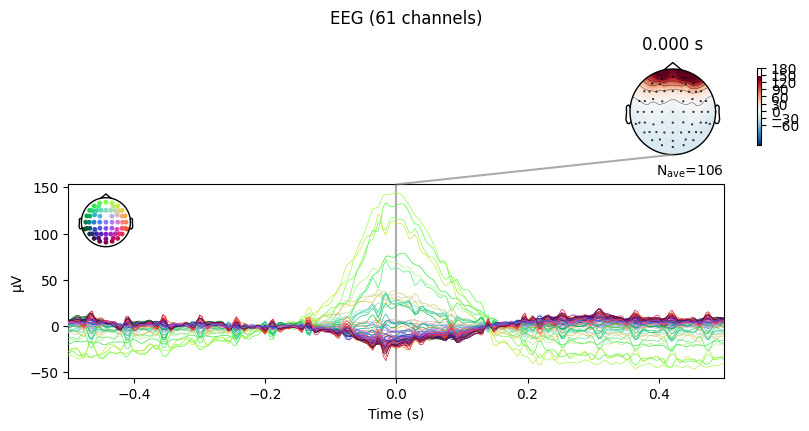

Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


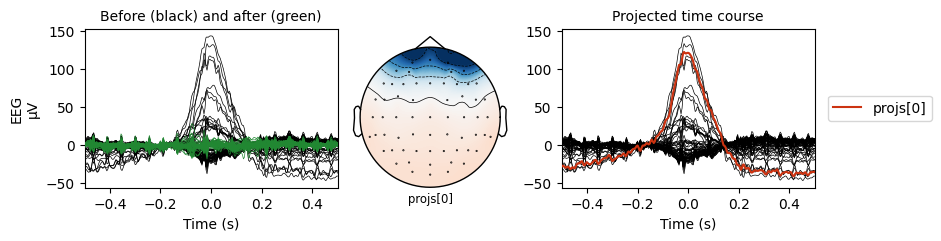

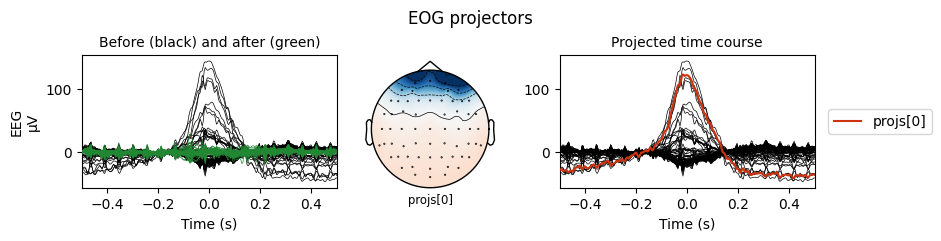

In [5]:
import mne
import numpy as np
from eeg_research.preprocessing.tools import (blinks_remover, 
                                              utils)
def merge_annotations(raw,annotations_list):
    """
    Merge multiple MNE Annotations objects into a single Annotations object.
    Overlapping annotations are merged into a single annotation with the description
    as a combination of the overlapping annotation descriptions.
    
    Parameters:
    - annotations_list: list of mne.Annotations objects to be merged
    
    Returns:
    - merged_annotations: MNE Annotations object containing all merged annotations
    """
    # Initialize empty lists for onsets, durations, and descriptions
    all_onsets = []
    all_durations = []
    all_descriptions = []
    
    # Collect all annotations
    for annotations in annotations_list:
        all_onsets.extend(annotations.onset)
        all_durations.extend(annotations.duration)
        all_descriptions.extend(annotations.description)
    
    # Convert to arrays for vectorized operations
    all_onsets = np.array(all_onsets)
    all_durations = np.array(all_durations)
    all_descriptions = np.array(all_descriptions)
    
    # Sort by onsets
    sorted_indices = np.argsort(all_onsets)
    all_onsets = all_onsets[sorted_indices]
    all_durations = all_durations[sorted_indices]
    all_descriptions = all_descriptions[sorted_indices]
    
    # Merge overlapping annotations
    merged_onsets = [all_onsets[0]]
    merged_durations = [all_durations[0]]
    merged_descriptions = [all_descriptions[0]]
    
    for i in range(1, len(all_onsets)):
        current_start = all_onsets[i]
        current_end = current_start + all_durations[i]
        last_end = merged_onsets[-1] + merged_durations[-1]
        
        if current_start <= last_end:
            # Overlapping, merge the current annotation with the last one
            merged_durations[-1] = max(last_end, current_end) - merged_onsets[-1]
            if all_descriptions[i] not in merged_descriptions[-1]:
                
                merged_descriptions[-1] = 'BAD_multi_artefacts'
        else:
            # No overlap, add as new annotation
            merged_onsets.append(current_start)
            merged_durations.append(all_durations[i])
            merged_descriptions.append(all_descriptions[i])
    
    # Create a new Annotations object with the merged data
    merged_annotations = mne.Annotations(onset=merged_onsets,
                                         duration=merged_durations,
                                         description=merged_descriptions,
                                         orig_time=raw.info['meas_date'])
    
    return merged_annotations

def annotate_artifacts_by_zscore(raw: mne.io.Raw, 
                                 description: str = 'BAD_other',
                                 channel_type: str | None ='eeg', 
                                 z_thresh: float=3.5, 
                                 min_artifact_gap: float | None =0.1, 
                                 minimum_duration: float | None =0.2,
                                 filtering: tuple[float | None] | None = (None, 8)):
    """
    Annotate and group artifacts in raw EEG data based on a z-score threshold, minimum gap criteria,
    and adjust annotations to meet a minimum duration.
    
    Parameters:
    - raw: Raw object from MNE containing EEG data.
    - channel_type: Type of channels to analyze.
    - z_thresh: Z-score threshold to use for detecting artifacts.
    - min_artifact_gap: Minimum time in seconds between separate artifacts; below this, artifacts will be grouped.
    - minimum_duration: Minimum duration for each annotation. If an annotation is shorter, it is adjusted.
    
    Returns:
    - annotations: MNE Annotations object with detected, grouped, and adjusted artifacts.
    """
    raw_copy = raw.copy()
    if filtering:
        raw_copy.filter(*filtering)
    if channel_type:
        picks = mne.pick_types(raw_copy.info, meg=False, eeg=(channel_type=='eeg'), eog=False)
    data, times = raw_copy[picks]
    z_scores = np.abs((data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True))
    artifacts = (z_scores > z_thresh).any(axis=0)
    gradient = np.diff(artifacts, prepend=0)
    rising_edge_idx = np.where(gradient == 1)[0]
    falling_edge_idx = np.where(gradient == -1)[0]
    if sum(artifacts) == 0:
        return mne.Annotations()  # Return empty annotations if no artifacts found

    onsets = times[rising_edge_idx]
    ends = times[falling_edge_idx]
    durations = np.array(ends) - np.array(onsets)
    adjusted_onsets = []
    adjusted_durations = []
    last_end = 0

    for i, (onset, duration) in enumerate(zip(onsets, durations)):
        if minimum_duration and duration < minimum_duration:
            new_onset = max(0, onset - (minimum_duration - duration) / 2)
            new_duration = minimum_duration
        else:
            new_onset = onset
            new_duration = duration
        
        # Merge annotations if they are closer than min_artifact_gap
        if adjusted_onsets and new_onset - last_end <= min_artifact_gap:
            # Extend the last annotation
            adjusted_durations[-1] = new_onset + new_duration - adjusted_onsets[-1]
        else:
            adjusted_onsets.append(new_onset)
            adjusted_durations.append(new_duration)
        
        last_end = adjusted_onsets[-1] + adjusted_durations[-1]

    descriptions = [description] * len(adjusted_onsets)
    annotations = mne.Annotations(onset=adjusted_onsets, 
                                  duration=adjusted_durations, 
                                  description=descriptions,
                                  orig_time = raw.info['meas_date'])
    return annotations


In [6]:
raw = mne.io.read_raw("/Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf",
                      preload = True)
b_remover = blinks_remover.BlinksRemover(raw)
montage = mne.channels.make_standard_montage('easycap-M1')
b_remover.raw.set_montage(montage)
#b_remover.plot_blinks_found()
b_remover.remove_blinks()
#b_remover.plot_removal_results()
raw = b_remover.blink_removed_raw
muscle_annotations, muscle_zscore = mne.preprocessing.annotate_muscle_zscore(raw,
                                                                             filter_freq=(30,None),
                                                                             
)
# Usage example
artifact_annotations = annotate_artifacts_by_zscore(raw, 
                                                    filtering = (1,None),
                                                    min_artifact_gap=0.25, 
                                                    minimum_duration=0.5)
annotation_list = [muscle_annotations, artifact_annotations]
merged = merge_annotations(raw, annotations_list=annotation_list)
raw.set_annotations(raw.annotations + merged)
raw.plot()

Extracting EDF parameters from /Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding ev

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 413 samples (1.652 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Using pyopengl with version 3.1.6


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Channels marked as bad:
none


In [4]:
raw.plot()

Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [3]:
mask_containing_bad = ["BAD" in description for description in merged.description]
index_bad = np.where(mask_containing_bad)

total_bad_seconds = merged.duration[index_bad].sum()
total_good_seconds = raw.times[-1] - total_bad_seconds

stats = dict(
    total_good = dict(seconds = total_good_seconds,
                      percentage = total_good_seconds * 100/raw.times[-1]),
    total_bad = dict(seconds = total_bad_seconds,
                     percentage = total_bad_seconds * 100/raw.times[-1])
)
descriptions = np.unique(merged.description)
for description in descriptions:
    description_index = np.where(merged.description == description)[0]
    total_seconds_this_description = merged.duration[description_index].sum()
    stats[str(description)] = dict(
        seconds = total_seconds_this_description,
        percentage = total_seconds_this_description * 100/raw.times[-1],
        percentage_from_bad = total_seconds_this_description * 100/total_bad_seconds
)


In [4]:
# plot
fig, ax = plt.subplots()
ax.pie(x, colors=colors, radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()

NameError: name 'plt' is not defined

([], [], [])

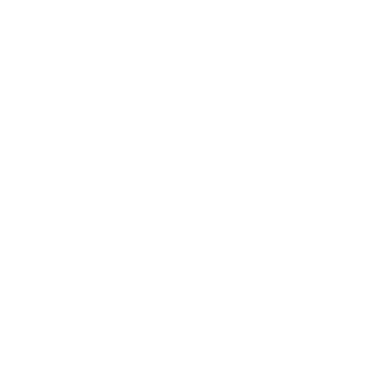

In [5]:
import matplotlib
from matplotlib import pyplot as plt
pie_values = [value for key, value in stats.items() if "percentage" in key]
fig, ax = plt.subplots()
ax.pie(pie_values,
       autopct="%1.1f%%")

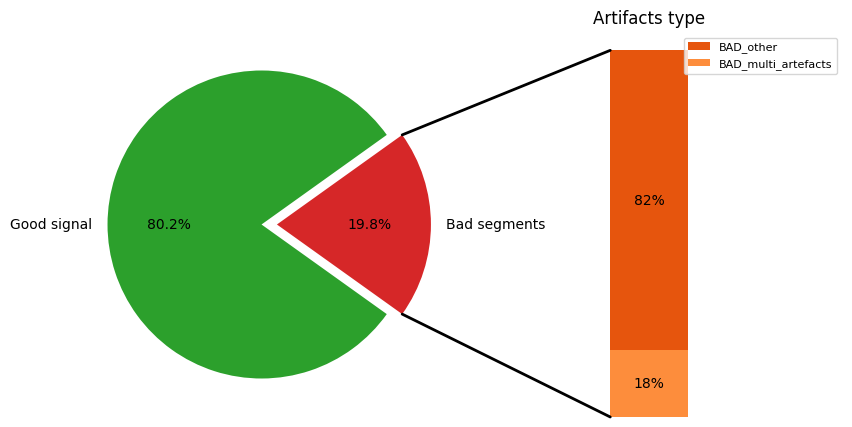

In [50]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch
import matplotlib as mpl

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [stats['total_bad']['percentage']/100, 
                  stats['total_good']['percentage']/100
]
labels = ['Bad segments', 'Good signal']
explode = [0.1, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, 
                     autopct='%1.1f%%', 
                     startangle=angle,
                     colors = ['tab:red', 'tab:green'],
                     labels=labels, 
                     explode=explode)

# bar chart parameters
artifacts_ratios = [value['percentartifacts_from_bad']/100 
                    for key,value in stats.items() 
                    if "BAD" in key]
artifacts_labels = [key for key in stats.keys() if 'BAD' in key]
bottom = 1
width = .2
cmap = mpl.colormaps['tab20c']
colors = cmap.colors[4:4+len(artifacts_ratios)]

# Adding from the top matches the legend.
for j, (height, label) in enumerate(
    reversed([*zip(artifacts_ratios, artifacts_labels)])
    ):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom,label=label,
                 color=colors[j])
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Artifacts type')
ax2.legend(fontsize = 8)
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(artifacts_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

In [42]:
colors

((0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882))

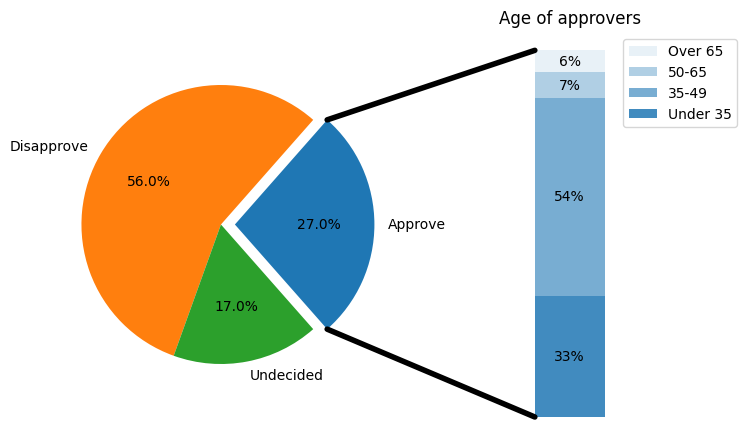

In [7]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import ConnectionPatch

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [.27, .56, .17]
labels = ['Approve', 'Disapprove', 'Undecided']
explode = [0.1, 0, 0]
# rotate so that first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_ratios = [.33, .54, .07, .06]
age_labels = ['Under 35', '35-49', '50-65', 'Over 65']
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of approvers')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[0].theta1, wedges[0].theta2
center, r = wedges[0].center, wedges[0].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(4)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(4)

plt.show()

# Test of the script

In [1]:
import mne
import numpy as np
import eeg_research.preprocessing.tools.blinks_remover as blinks_remover
import eeg_research.preprocessing.tools.artifacts_annotator as annotator
raw = mne.io.read_raw("/Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf",
                      preload = True)
b_remover = blinks_remover.BlinksRemover(raw)
montage = mne.channels.make_standard_montage('easycap-M1')
b_remover.raw.set_montage(montage)
#b_remover.plot_blinks_found()
b_remover.remove_blinks()
#b_remover.plot_removal_results()
raw = b_remover.blink_removed_raw

Extracting EDF parameters from /Users/samuel/Downloads/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...
Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding ev

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [2]:
# Testing muscle annotations
raw_copy = raw.copy()
z_annotator = annotator.ZscoreAnnotator(raw_copy)
z_annotator.detect_muscles(filter_freq = (30,100))
z_annotator.detect_other_artifacts(filtering=(None,30),
                                   min_artifact_gap= 0.2,
                                   minimum_duration=0.2)
z_annotator.merge_annotations()

Using eeg sensors for muscle artifact detection
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 111 samples (0.444 s)

Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 111 samples (0.444 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


In [3]:
z_annotator.compute_statistics().print_statistics()


ARTIFACT ANNOTATIONS STATISTICS
        EEG total duration:.................... 242.0s
        Number of bad segment annotated:....... 61
        Total duration of bad segments:........ 34.05s (14.07%)
        Total duration of good signal:......... 207.94s (85.93%)

        Types of artifacts annotated: BAD_others, BAD_others_muscle
                |__BAD_others duration (sec): 27.56s (11.39%)
                |__BAD_others_muscle duration (sec): 6.49s (2.68%)


In [6]:
np.round(z_annotator.statistics['tot_bad']['ratio'],2)

0.14

In [3]:
artifacts_general_annotations = annotation_list.copy()
def merge_annotations(artifacts_general_annotations,
                      raw) -> 'ZscoreAnnotator':
        """Merge MNE Annotations objects into a single Annotations object.
        
        Overlapping annotations are merged into a single annotation with the 
        description as a combination of the overlapping annotation descriptions.
        
        Returns:
        - merged_annotations: MNE Annotations object containing all merged annotations
        """
        annots_args_list: dict[list] = {
            "onset": [],
            "duration": [],
            "description": []
        }
        
        for annot_arg_name, annot_arg_var in annots_args_list.items():
            for annotations in artifacts_general_annotations:
                annots_args_list[annot_arg_name] = annot_arg_var.extend(
                    getattr(annotations, annot_arg_name)
                    )

            annots_args_list[annot_arg_name] = np.sort(annot_arg_var)
        
        merged_onsets = [annots_args_list['onset'][0]]
        merged_durations = [annots_args_list['duration'][0]] 
        merged_descriptions = [annots_args_list['description'][0]]
        
        for i in range(1, len(annots_args_list['onset'])):
            current_start = annots_args_list['onset'][i]
            current_end = current_start + annots_args_list['duration'][i]
            last_end = merged_onsets[-1] + merged_durations[-1]
            
            if current_start <= last_end:
                merged_durations[-1] = max(last_end, current_end) - merged_onsets[-1]
                if annots_args_list['description'][i] not in merged_descriptions[-1]:
                    
                    merged_descriptions[-1] += '_' + annots_args_list['description'][i][4:]
            else:
                merged_onsets.append(current_start)
                merged_durations.append(annots_args_list['duration'][i])
                merged_descriptions.append(annots_args_list['description'][i])
        
        artifact_annotations = mne.Annotations(onset=merged_onsets,
                                            duration=merged_durations,
                                            description=merged_descriptions,
                                            orig_time= raw.info['meas_date'])
        return artifact_annotations

annot = merge_annotations(artifacts_general_annotations,raw)
raw.set_annotations(annot)
raw.plot()

/var/folders/l3/myr9vj8933q4vwhkbvxcx6gc0000gn/T/ipykernel_3971/2082992089.py:50: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annot)


Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none


In [10]:
print(getattr(annotation_list[0],'onset'))

[ 19.144  19.928  27.016 237.   ]


In [1]:
raw

NameError: name 'raw' is not defined

In [3]:
filename = '/Users/samuel/Desktop/testing_export.edf'
mne.export.export_raw(filename ,z_annotator.raw, fmt = 'edf', overwrite=True)
raw = mne.io.read_raw(filename)
raw.plot()

Overwriting existing file.
Extracting EDF parameters from /Users/samuel/Desktop/testing_export.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Using qt as 2D backend.
Using pyopengl with version 3.1.6


Channels marked as bad:
none
